In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import Dict, List
import random

class Analyzer:

    def __init__(self, model: nn.Module, base_model: nn.Module, device: str = 'cpu',seed=42, is_random = True, layer_numbers = 12):
        self.model = model.to(device)
        self.base_model = base_model.to(device)
        self.device = device
        self.hooks = []
        self.layer_data: Dict[str, Dict[str,List[torch.Tensor]]] = {}
        rng = random.Random(seed)
        self._find_linear_layers(rng, rnd = is_random, numbers = layer_numbers)

    def _find_linear_layers(self, rng, rnd, numbers):
        self.linear_layers = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                # find corresponding base layer
                base_module = dict(self.base_model.named_modules()).get(name, None)
                if base_module is None:
                    raise ValueError(f"Layer {name} not found in base_model")
                self.linear_layers.append((name, module, base_module))
        if rnd == True:
            self.linear_layers = rng.sample(self.linear_layers, numbers)
    
    def remove_hooks(self):
        for h in self.hooks:
            h.remove()
        self.hooks.clear()

    def register_hooks(self):
        for name, layer, _ in self.linear_layers:
            self.layer_data[name] = {'X': [], 'H': []}
            def hook(module, inputs, output,layer_name=name):
                    # inputs is a tuple; take inputs[0]
                    X = inputs[0].detach().cpu()
                    H = output.detach().cpu()
                    self.layer_data[layer_name]['X'].append(X)
                    self.layer_data[layer_name]['H'].append(H)
            handle = layer.register_forward_hook(hook)
            self.hooks.append(handle)
    
    def collect_features(self, dataloader: DataLoader, input_key: str = 'input'):
        self.model.eval()
        with torch.no_grad():
            for batch in dataloader:
                # assume batch is dict with tensor 'input'
                inputs = {k: v.to(self.device) for k, v in batch.items()}
                _ = self.model(**inputs)
                
        # concatenate per-layer
        for name in self.layer_data:
            self.layer_data[name]['X'] = torch.cat(self.layer_data[name]['X'], dim=0)
            self.layer_data[name]['H'] = torch.cat(self.layer_data[name]['H'], dim=0)   
    
    def get_layer_svds(self, truncate: bool = False, flavor = 'dimension', truncate_p: float = 0.2) -> Dict[str, List[torch.Tensor]]:
        svd_dict: Dict[str, List[torch.Tensor]] = {}

        for name, layer, base_layer in self.linear_layers:
            W = layer.weight.detach().cpu()
            W0 = base_layer.weight.detach().cpu()
            tau = W-W0
            U, S, Vh = torch.linalg.svd(tau, full_matrices = False)
            V = Vh.T

            if truncate:
                assert 0 <= truncate_p <= 1, "truncate percentage must be between 0 and 1"
                if flavor == 'dimension':
                    rank = int(truncate_p * S.size(0))
                    if rank<1: 
                        rank = 1
                    U=U[:,:rank]
                    S=S[:rank]
                    V=V[:, :rank]
                elif flavor == 'energy':
                    tot = torch.square(S).sum()
                    if tot != 0:
                        threshold = truncate_p * tot
                        cumsum = torch.cumsum(torch.square(S), dim=0)
                        ranks = (cumsum >= threshold).nonzero(as_tuple=False)
                        rank = ranks[0].item()
                        if len(ranks) == 0:
                            rank = len(S)
                    U=U[:, :rank]
                    S=S[:rank]
                    V=V[:, :rank]
            
            svd_dict[name] = [U,S,V]

        return svd_dict

    def get_layer_inputs(self) -> Dict[str, torch.Tensor]:
        return {name: data['X'] for name, data in self.layer_data.items()}

    def get_layer_hiddens(self) -> Dict[str, torch.Tensor]:
        return {name: data['H'] for name, data in self.layer_data.items()}


In [2]:
import math
import numpy as np

def compute_drift(ft_dict, pt_dict):
    return {name: (ft_dict[name]-pt_dict[name]) for name in ft_dict.keys()}

def avg_proj_error(
    data_dict: Dict[str, torch.Tensor], 
    svd_dict: Dict[str,List[torch.Tensor]],
    part: str = 'V',
    device: str = None,
) -> Dict[str, float]:

    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    
    result : Dict[str, float] = {}
    for name, M in data_dict.items():
        M = M.to(device)
        U,S,V = svd_dict[name]
        basis = (V if part == 'V' else U).to(device)
        M_recenter = M - M.mean(0, keepdim=True)
        P = M_recenter @ basis @ basis.T
        R = M_recenter - P
        rel = (R.norm(dim=1)**2 / M_recenter.norm(dim=1)**2).mean().item()
        result[name]=rel
    return result

def U_V_alignment(
    t1_svd_dict: Dict[str, List[torch.Tensor]],
    t2_svd_dict: Dict[str, List[torch.Tensor]],
    device: str = None
) -> Dict[str, torch.Tensor]:
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)

    results: Dict[str, torch.Tensor] = {}
    for layer_name, (U1, _, V1) in t1_svd_dict.items():
        U1 = U1.to(device)        # [d_out, r1]
        V1 = V1.to(device)        # [d_in,  r1]
        U2, _, V2 = t2_svd_dict[layer_name]
        U2 = U2.to(device)        # [d_out, r2]
        V2 = V2.to(device)        # [d_in,  r2]

        P_u1 = U1 @ U1.T          # [d_out, d_out]
        P_u2 = U2 @ U2.T          # [d_out, d_out]
        overlap_U = torch.norm(P_u1 @ P_u2, p='fro') / math.sqrt(min(U1.shape[1], U2.shape[1]))

        P_v1 = V1 @ V1.T          # [d_in, d_in]
        P_v2 = V2 @ V2.T          # [d_in, d_in]
        overlap_V = torch.norm(P_v1 @ P_v2, p='fro') / math.sqrt(min(V1.shape[1], V2.shape[1]))

        results[layer_name] = torch.tensor([overlap_U, overlap_V], device=device)

    return results

def cos_similarity(
    t1_svd_dict: Dict[str, List[torch.Tensor]],
    t2_svd_dict: Dict[str, List[torch.Tensor]],
    device: str = None
) -> Dict[str, float]:
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)

    results: Dict[str, float] = {}
    for layer_name, (U1, S1, V1) in t1_svd_dict.items():
        U1 = U1.to(device)        # [d_out, r1]
        V1 = V1.to(device)        # [d_in,  r1]
        S1 = S1.to(device)
        tau1 = U1 @ torch.diag_embed(S1) @ V1.T
        
        U2, S2, V2 = t2_svd_dict[layer_name]
        U2 = U2.to(device)        # [d_out, r2]
        V2 = V2.to(device)        # [d_in,  r2]
        S2 = S2.to(device)
        tau2 = U2 @ torch.diag_embed(S2) @ V2.T
        
        cos = torch.norm(tau1.T @ tau2) / (torch.norm(tau1)*torch.norm(tau2))

        results[layer_name] = cos

    return results
    

In [3]:
import matplotlib.pyplot as plt
import math

def plot_data_alignment(results_dict: Dict[str, Dict[str, float]]):
    # Extract layer names and dataset names
    dataset_names = list(results_dict.keys())
    # Assume all results have the same layer keys
    layer_names = list(next(iter(results_dict.values())).keys())
    
    # Build matrix of errors
    data_matrix = []
    for d in dataset_names:
        row = [results_dict[d][layer] for layer in layer_names]
        data_matrix.append(row)
    data_matrix = torch.tensor(data_matrix, dtype=torch.float32)
    
    # Plot
    plt.figure()
    plt.imshow(data_matrix, aspect='auto')
    plt.colorbar(label='Projection Error')
    plt.xticks(ticks=range(len(layer_names)), labels=layer_names, rotation=45, ha='right')
    plt.yticks(ticks=range(len(dataset_names)), labels=dataset_names)
    plt.xlabel('Layer')
    plt.ylabel('Dataset')
    plt.title('Layerwise Data Alignment Error Heatmap')
    plt.tight_layout()
    plt.show()

def plot_U_V_alignment(alignment_dict: Dict[str, torch.Tensor]):
    # Extract layers and corresponding values
    layers = list(alignment_dict.keys())
        
    U_vals = []
    V_vals = []
    
    for layer in layers:
        vals = alignment_dict[layer]
        layer= layer.replace("vision_model.", "")
        # Ensure tensor on CPU and convert to floats
        U_vals.append(vals[0].cpu().item())
        V_vals.append(vals[1].cpu().item())
    
    # Plot
    plt.figure()
    plt.figure(figsize=(16,8))
    plt.plot(layers, U_vals, marker='o', label='U alignment')
    plt.plot(layers, V_vals, marker='s', label='V alignment')
    plt.xticks(ticks=layers, labels=layers, rotation=45, ha='right')
    plt.xlabel('Layer')
    plt.ylabel('Subspace Overlap')
    plt.title('U vs V Subspace Alignment per Layer')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_cos_similarity(alignment_dict,cmap: str = "viridis"):
    # Extract layers and corresponding values
    layers = list(alignment_dict.keys())
        
    data = []
    
    for layer in layers:
        v = alignment_dict[layer]
        if isinstance(v, torch.Tensor):
            v = v.detach().cpu().numpy()
        else:
            v = np.array(v, dtype=float)
        data.append(v)
       
        # Ensure tensor on CPU and convert to floats
        #cos.append(val)
    data = np.vstack(data)
    display_layers = [l.replace("vision_model.", "") for l in layers]
    
    # Plot
    plt.figure()
    plt.figure(figsize=(12, max(4, len(layers) * 0.4)))
    im = plt.imshow(data, aspect="auto", cmap=cmap)
    plt.colorbar(im, label="Cosine similarity")
    plt.yticks(np.arange(len(display_layers)), display_layers, fontsize=8)
    plt.xticks(
        np.arange(data.shape[1]),
        np.arange(data.shape[1]),
        rotation=45,
        ha="right",
        fontsize=8
    )
    plt.xlabel("Component index")
    plt.ylabel("Layer")
    plt.title("Subspace overlap heatmap per layer")
    plt.tight_layout()
    plt.show()

In [4]:
'''for different ft models, compute the linear layer weight orthogonality and corresponding U, V alignments.'''

# Sample cell: Compare two models layerwise subspace alignment

import torch
from transformers import CLIPVisionModel
import matplotlib.pyplot as plt

# Assume ModelAnalyzer, U_V_alignment, plot_U_V_alignment are defined in previous cells
# from your_notebook import ModelAnalyzer, U_V_alignment, plot_U_V_alignment

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) Download base and two finetuned models from Hugging Face
base_name   = "openai/clip-vit-base-patch32"
model1_name = "tanganke/clip-vit-base-patch32_mnist"  # replace with your first finetuned repo
model2_name = "tanganke/clip-vit-base-patch32_stl10"  # replace with your second finetuned repo

base_model  = CLIPVisionModel.from_pretrained(base_name, output_hidden_states=True).to(device)
model1      = CLIPVisionModel.from_pretrained(model1_name, output_hidden_states=True).to(device)
model2      = CLIPVisionModel.from_pretrained(model2_name, output_hidden_states=True).to(device)

# 2) Compute layerwise τ‐SVD for each task
analyzer1 = Analyzer(model1, base_model, device=device)
svd_dict1 = analyzer1.get_layer_svds(truncate=True, truncate_p=0.1)

analyzer2 = Analyzer(model2, base_model, device=device)
svd_dict2 = analyzer2.get_layer_svds(truncate=True, truncate_p=0.1)

# 3) Compare U and V subspace alignments per layer
alignment = U_V_alignment(svd_dict1, svd_dict2, device=device)




2025-07-31 17:45:50.935751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753983951.129472      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753983951.186094      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

<Figure size 640x480 with 0 Axes>

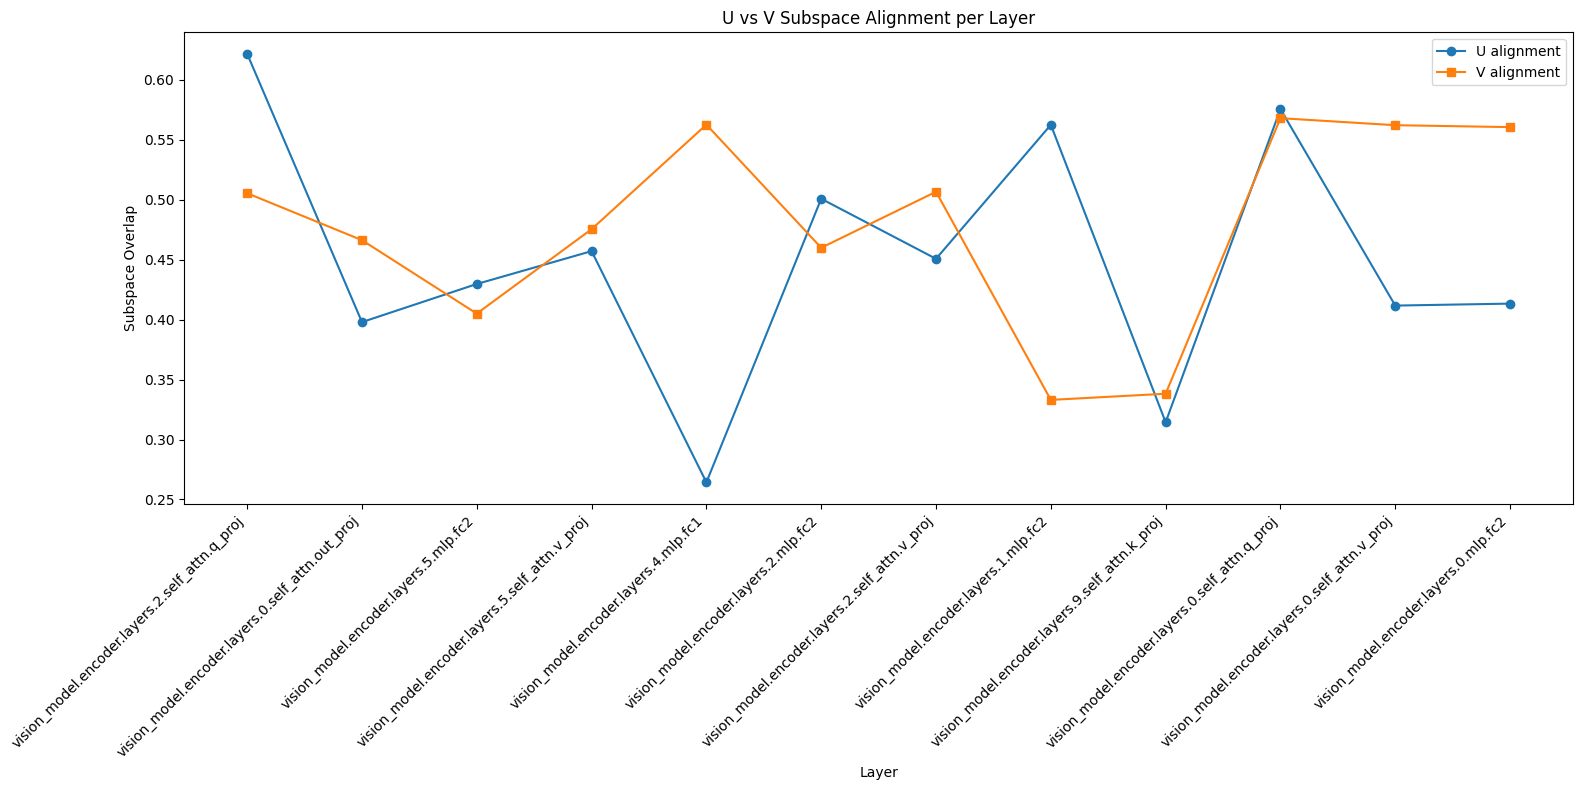

In [5]:
plot_U_V_alignment(alignment)

In [6]:
#similarity = cos_similarity(svd_dict1, svd_dict2, device)

In [7]:
#plot_cos_similarity(similarity)

In [8]:
import scipy
from scipy.linalg import polar

def compute_left_basis(P,S,W,eps):
    #print("foo")
    p,k = P.size()
    M=P@W #p*k

    
    if p > k:
        pad = torch.zeros((p, p-k), device=M.device, dtype=M.dtype)
        A_pad = torch.cat([M, pad], dim=1)  # p×p
    else:
        A_pad = M

    #A_pad += 
    A_np = A_pad.cpu().numpy() + eps*torch.eye(p).numpy()
    V_np, R_np = polar(A_np, side='right')

    V = torch.from_numpy(V_np).to(device=M.device, dtype=M.dtype)
    R = torch.from_numpy(R_np).to(device=M.device, dtype = M.dtype)

    return V,R

def ql(M):
    #print("bar")
    p,k = M.size()
    J = torch.flip(torch.eye(k, device=M.device), dims=[1])
    V,R = torch.linalg.qr(M.T)
    N = R@J
    assert np.allclose(V @ N, M, atol=1e-8)
    return V, N

def gsvd(A:torch.tensor,
         B:torch.tensor,
         #truncate: bool = True
)->[torch.tensor]:
    '''
    TODO: fix precision issue for m < n
    '''
    '''
    Does G-SVD on two matrices, A, B, both m x n.

    Input:
        A, B: tensors, matrices

    Output:
        a list of tensors: [U,S_A,V,S_B,W,R,Q], where
            A = U (S_A) (W^T (R)) Q^T
            B = V (S_B) (W^T (R)) Q^T
        U, V, W, Q are unitary matrices
    '''
    
    #Paige and Saunders 1981, section 2
    eps = 1e-12
    m,n = A.size()
    p,_ = B.size()
    
    #joint svd of A, B
    C = torch.vstack([A,B])
    P,R,Qh = torch.linalg.svd(C, full_matrices = True) #2m x 2m, min(2m,n), n x n
    Q = Qh.T
    #print(R)
    
    R_energy = R**2
    Rcumsum = torch.cumsum(R_energy, dim=0)
    total = R_energy.sum()
    k = int((Rcumsum >=  0.99 * total).nonzero()[0].item()) + 1
    #nonzero = R > eps
    #k = nonzero.sum().item()

    k = min(m,k)
    #print(torch.linalg.matrix_rank(C),torch.linalg.matrix_rank(A), torch.linalg.matrix_rank(B))
    R = R[:k] #diag(R) is k x k
    
    #calculate U, Sigma_A
    P1 = P[:m,:k] #m x k
    U, alpha, Wh = torch.linalg.svd(P1, full_matrices = True) #U is m * m, W is k * k, alpha is min(m,k)
    W = Wh.T
    
    Sigma_A = torch.zeros((m,k), device = A.device, dtype = A.dtype)
    for j in range(min(m,k)):
        Sigma_A[j,j] = alpha[j]
    #Sigma_A is m x k
    
    #calculate Sigma_B\
    
    P2 = P[m:,:k]
    M=P2@W

    beta = torch.sqrt(torch.clamp(1.0-alpha**2, min=0.0))

    V,_ = compute_left_basis(P2, beta, W, eps)#[:,:p] #compute the best orthonormal V such that V^T (P2 W) = Sigma_B 
    
    #V, beta, _ = torch.linalg.svd(P2 @ W, full_matrices=True)
    
    Sigma_B = torch.zeros((p,k), device = B.device, dtype = B.dtype)
    for j in range(min(p,k)):
        Sigma_B[j,j] = beta[j]

    #print(torch.norm(P2 - V @ Sigma_B @ W.T))
    #print(torch.norm(P2 - V @ R @ W.T))
    #print(torch.norm(P1 - U @ Sigma_A @ W.T))
    #V,Sigma_B = torch.linalg.qr(M)
    
    return [U,Sigma_A,V,Sigma_B,W,torch.diag(R),Q,k]

In [9]:
A = torch.rand(400,500)

B = torch.rand(400,500)

U,S_A,V,S_B,W,R,Q,k = gsvd(A,B)
#U,V,X,C,S = matlab_gsvd(A,B)
#print(np.linalg.norm( A - (U @ C @ X.T.conj() )))
#print(np.linalg.norm( B - (V @ S @ X.T.conj() )))

print(U.shape, S_A.shape, V.shape, S_B.shape, W.shape, R.shape, Q.shape,k)
#print(S_B.diag())
n=Q.shape[0]
WtR = W.T@R
if k < n:
    zeros_pad = torch.zeros((k, n - k), device=WtR.device, dtype=WtR.dtype)
    WtR= torch.cat([WtR, zeros_pad], dim=1)
M = WtR

print(torch.norm(A-U@S_A@M@Q.T)/torch.norm(A))
print(torch.norm(B-V@S_B@M@Q.T)/torch.norm(B))

torch.Size([400, 400]) torch.Size([400, 383]) torch.Size([400, 400]) torch.Size([400, 383]) torch.Size([383, 383]) torch.Size([383, 383]) torch.Size([500, 500]) 383
tensor(0.0992)
tensor(0.0997)


In [10]:
print(V)

tensor([[ 0.0129, -0.0640,  0.0883,  ...,  0.0397, -0.0727,  0.0263],
        [ 0.0142,  0.0692,  0.0620,  ...,  0.0058, -0.0767, -0.0205],
        [ 0.0231,  0.0473, -0.0183,  ...,  0.0667,  0.0288, -0.0550],
        ...,
        [-0.0112,  0.0465,  0.0467,  ..., -0.0270,  0.0155, -0.0195],
        [-0.0353,  0.0279, -0.0476,  ..., -0.0376, -0.1111,  0.0543],
        [-0.0544, -0.0262, -0.0044,  ...,  0.0539,  0.0361, -0.0022]])


In [11]:
def gsvd_left_similarity(
    t1_svd_dict: Dict[str, List[torch.Tensor]],
    t2_svd_dict: Dict[str, List[torch.Tensor]],
    device: str = None
) -> Dict[str, float]:
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)

    results: Dict[str, float] = {}
    for layer_name, (U1, S1, V1) in t1_svd_dict.items():
        U1 = U1.to(device)        # [d_out, r1]
        V1 = V1.to(device)        # [d_in,  r1]
        S1 = S1.to(device)
        tau1 = U1 @ torch.diag_embed(S1) @ V1.T

        U2, S2, V2 = t2_svd_dict[layer_name]
        U2 = U2.to(device)        # [d_out, r2]
        V2 = V2.to(device)        # [d_in,  r2]
        S2 = S2.to(device)
        tau2 = U2 @ torch.diag_embed(S2) @ V2.T
        #print(layer_name)
        print(torch.linalg.matrix_rank(tau1), torch.linalg.matrix_rank(tau2))
        U,S_A,V,S_B,W,R,Q,k = gsvd(tau1, tau2)
        #print(k)
        r=100
        
        
        U_r = U[:, :r]          
        V_r = V[:, -r:]          
        #C   = U_k.T @ V_k       
        cos = torch.norm(U_r.T @ V_r) / (torch.norm(U_r)*torch.norm(V_r))
        print(torch.norm(U_r.T@V_r))
        
        results[layer_name] = cos
    return results

In [12]:
similarity = gsvd_left_similarity(svd_dict1, svd_dict2, device=device)
#plot_cos_similarity(similarity)

tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(3.1480, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(3.4581, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(3.4771, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(3.4121, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(1.7513, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(3.3659, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(3.3897, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(3.2565, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(3.5930, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(3.2034, device='cuda:0')
tensor(76, device='cuda:0') tensor(76, device='cuda:0')
tensor(3.4710, device='cuda:0')
tensor(76, device='cuda:0') tens

<Figure size 640x480 with 0 Axes>

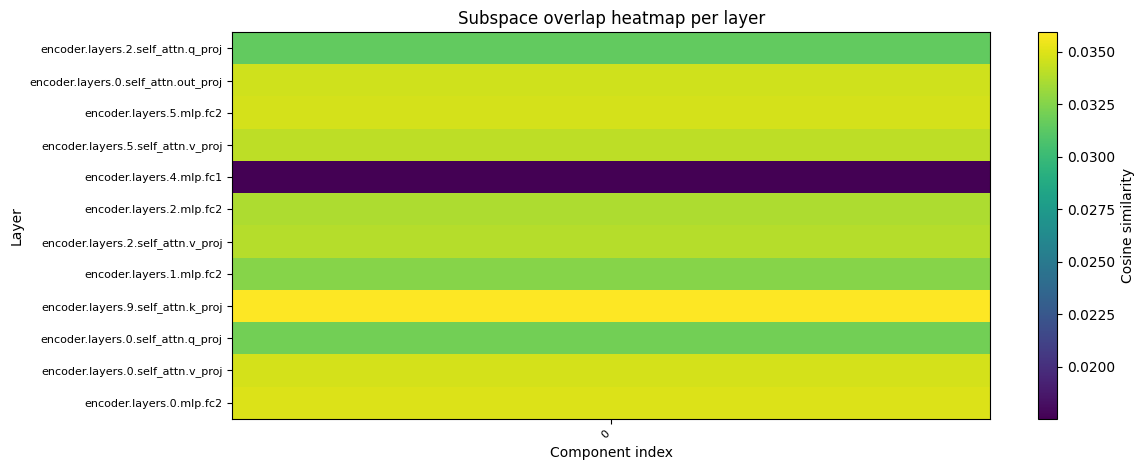

In [13]:
plot_cos_similarity(similarity)

In [14]:
#plot_random_gsvd_S(svd_dict1, svd_dict2)

In [15]:
import torch
import random
import matplotlib.pyplot as plt

def plot_random_gsvd_S(t1_svd_dict, t2_svd_dict, num_layers=4, seed=None):
    """
    Randomly select layers and plot the distributions of S_A and S_B from GSVD
    for each selected layer. Each layer gets its own plot.
    
    Args:
        t1_svd_dict (dict): Mapping layer_name -> (U1, S1, V1) for model 1.
        t2_svd_dict (dict): Mapping layer_name -> (U2, S2, V2) for model 2.
        num_layers (int): Number of layers to randomly select.
        seed (int, optional): Random seed for reproducibility.
    """
    if seed is not None:
        random.seed(seed)
    
    # Ensure deterministic selection if fewer layers than requested
    layer_names = list(set(t1_svd_dict.keys()) & set(t2_svd_dict.keys()))
    selected = random.sample(layer_names, min(num_layers, len(layer_names)))
    
    for layer in selected:
        # Reconstruct tau matrices
        U1, S1, V1 = t1_svd_dict[layer]
        tau1 = U1 @ torch.diag_embed(S1) @ V1.T
        
        U2, S2, V2 = t2_svd_dict[layer]
        tau2 = U2 @ torch.diag_embed(S2) @ V2.T
        
        # Compute GSVD
        U, S_A, V, S_B, W_R, R_mat, Q, k = gsvd(tau1, tau2)
        
        # Plot distributions
        plt.figure()
        plt.plot(torch.diag(S_A).numpy(), label='S_A')
        plt.plot(torch.diag(S_B).numpy(), label='S_B')
        plt.plot(torch.diag(R_mat).numpy(), label = 'R')
        plt.title(f"Layer: {layer} GSVD Singular Values")
        plt.xlabel("Component Index")
        plt.ylabel("Singular Value")
        plt.legend()
        plt.show()


In [16]:
from datasets import load_dataset
from transformers import CLIPVisionModel, CLIPProcessor
from torch.utils.data import DataLoader
import torch

model_names = [
    "tanganke/clip-vit-base-patch32_mnist", 
    "tanganke/clip-vit-base-patch32_sun397"
]
base_model_name = "openai/clip-vit-base-patch32"
dataset_infos = [
    {"hf_name": "ylecun/mnist",       "split": "train[:1%]"},
    {"hf_name": "tanganke/sun397",    "split": "train[:1%]"}
]


device = "cuda" if torch.cuda.is_available() else "cpu"
X_dicts = {}
H_dicts = {}
SVD_dicts = {}

processor = CLIPProcessor.from_pretrained(base_model_name)

for model_name in model_names:
    # Load models
    model = CLIPVisionModel.from_pretrained(model_name, output_hidden_states=True).to(device)
    base_model = CLIPVisionModel.from_pretrained(base_model_name, output_hidden_states=True).to(device)
    analyzer = Analyzer(model, base_model, device=device)
    for ds_info in dataset_infos:
        ds_name = ds_info["hf_name"]
        split = ds_info["split"]
        
        # Load and preprocess dataset
        ds = load_dataset(ds_name, split=split)
        # Detect image column
        from datasets.features import Image as HfImageFeature
        img_col = next(k for k, f in ds.features.items() if isinstance(f, HfImageFeature))
        #print("Using image column:", img_col)
        
        def preprocess(batch):
            enc = processor(images=batch[img_col], return_tensors="pt", padding=True)
            return {"pixel_values": enc["pixel_values"]}
        
        ds_proc = ds.map(preprocess, batched=True, remove_columns=ds.column_names)
        ds_proc.set_format(type="torch", columns=["pixel_values"])
        loader = DataLoader(ds_proc, batch_size=16, shuffle=False)
        
        # Analyze
        analyzer.register_hooks()
        analyzer.collect_features(loader)
        analyzer.remove_hooks()
        
        # Extract dictionaries
        X_dict = analyzer.get_layer_inputs()
        H_dict = analyzer.get_layer_hiddens()
        
        # Store
        X_dicts[(model_name, ds_name)] = X_dict
        H_dicts[(model_name, ds_name)] = H_dict
    
    svd_dict = analyzer.get_layer_svds(truncate=True, flavor = 'energy',truncate_p = 0.9)
    SVD_dicts[model_name] = svd_dict

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

data/train-00000-of-00018.parquet:   0%|          | 0.00/458M [00:00<?, ?B/s]

data/train-00001-of-00018.parquet:   0%|          | 0.00/364M [00:00<?, ?B/s]

data/train-00002-of-00018.parquet:   0%|          | 0.00/367M [00:00<?, ?B/s]

data/train-00003-of-00018.parquet:   0%|          | 0.00/433M [00:00<?, ?B/s]

data/train-00004-of-00018.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

data/train-00005-of-00018.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00006-of-00018.parquet:   0%|          | 0.00/440M [00:00<?, ?B/s]

data/train-00007-of-00018.parquet:   0%|          | 0.00/356M [00:00<?, ?B/s]

data/train-00008-of-00018.parquet:   0%|          | 0.00/394M [00:00<?, ?B/s]

data/train-00009-of-00018.parquet:   0%|          | 0.00/380M [00:00<?, ?B/s]

data/train-00010-of-00018.parquet:   0%|          | 0.00/346M [00:00<?, ?B/s]

data/train-00011-of-00018.parquet:   0%|          | 0.00/377M [00:00<?, ?B/s]

data/train-00012-of-00018.parquet:   0%|          | 0.00/387M [00:00<?, ?B/s]

data/train-00013-of-00018.parquet:   0%|          | 0.00/417M [00:00<?, ?B/s]

data/train-00014-of-00018.parquet:   0%|          | 0.00/394M [00:00<?, ?B/s]

data/train-00015-of-00018.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

data/train-00016-of-00018.parquet:   0%|          | 0.00/380M [00:00<?, ?B/s]

data/train-00017-of-00018.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

data/test-00000-of-00018.parquet:   0%|          | 0.00/450M [00:00<?, ?B/s]

data/test-00001-of-00018.parquet:   0%|          | 0.00/365M [00:00<?, ?B/s]

data/test-00002-of-00018.parquet:   0%|          | 0.00/353M [00:00<?, ?B/s]

data/test-00003-of-00018.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

data/test-00004-of-00018.parquet:   0%|          | 0.00/467M [00:00<?, ?B/s]

data/test-00005-of-00018.parquet:   0%|          | 0.00/409M [00:00<?, ?B/s]

data/test-00006-of-00018.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

data/test-00007-of-00018.parquet:   0%|          | 0.00/408M [00:00<?, ?B/s]

data/test-00008-of-00018.parquet:   0%|          | 0.00/365M [00:00<?, ?B/s]

data/test-00009-of-00018.parquet:   0%|          | 0.00/397M [00:00<?, ?B/s]

data/test-00010-of-00018.parquet:   0%|          | 0.00/380M [00:00<?, ?B/s]

data/test-00011-of-00018.parquet:   0%|          | 0.00/360M [00:00<?, ?B/s]

data/test-00012-of-00018.parquet:   0%|          | 0.00/348M [00:00<?, ?B/s]

data/test-00013-of-00018.parquet:   0%|          | 0.00/388M [00:00<?, ?B/s]

data/test-00014-of-00018.parquet:   0%|          | 0.00/401M [00:00<?, ?B/s]

data/test-00015-of-00018.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

data/test-00016-of-00018.parquet:   0%|          | 0.00/424M [00:00<?, ?B/s]

data/test-00017-of-00018.parquet:   0%|          | 0.00/366M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19850 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19850 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

In [17]:
energies  = {}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

combos = list(X_dicts.keys())
print(len(combos))

svd_dict_1 = SVD_dicts[model_names[0]]
svd_dict_2 = SVD_dicts[model_names[1]]

for layer_name, (U1, S1, V1) in svd_dict_1.items():
    U1 = U1.to(device)        # [d_out, r1]
    V1 = V1.to(device)        # [d_in,  r1]
    S1 = S1.to(device)
    tau1 = U1 @ torch.diag_embed(S1) @ V1.T
        
    U2, S2, V2 = svd_dict_2[layer_name]
    U2 = U2.to(device)        # [d_out, r2]
    V2 = V2.to(device)        # [d_in,  r2]
    S2 = S2.to(device)
    tau2 = U2 @ torch.diag_embed(S2) @ V2.T

    U,Sigma_1,V,Sigma_2,W,R,Q,k = gsvd(tau1,tau2)
    print(U.shape,Sigma_1.shape,V.shape,Sigma_2.shape, W.shape,R.shape,Q.shape,k,torch.diag(Sigma_1).min().item())

    tot = torch.square(torch.diag(R)).sum()
    #threshold = 0.8 * tot
    #cumsum = torch.cumsum(torch.square(torch.diag(R)),dim=0)
    #rank = (cumsum >= threshold).nonzero(as_tuple=False)[0].item()
    #R[rank:,rank:]=0
    
    n=Q.shape[0]
    WtR = W.T@R
    if k < n:
        zeros_pad = torch.zeros((k, n - k), device=WtR.device, dtype=WtR.dtype)
        WtR= torch.cat([WtR, zeros_pad], dim=1)
    M = WtR@Q.T

    layer_energies = []
    for combo in combos:
        if combo[0] == model_names[0]:
            Sigma = Sigma_1
        else:
            Sigma = Sigma_2
        X = X_dicts[combo][layer_name]
        X = X.to(M.device)
       
        Xflat = X.reshape(-1,X.size(dim=-1))
        Yflat = Xflat@(M.T)
        e = (Yflat.pow(2)).mean(dim=0)
        #e = torch.diag(WtR@WtR.T)
        layer_energies.append(e.cpu())
    energies[layer_name] = (layer_energies,torch.diag(Sigma_1),torch.diag(Sigma_2))

4
torch.Size([768, 768]) torch.Size([768, 172]) torch.Size([768, 768]) torch.Size([768, 172]) torch.Size([172, 172]) torch.Size([172, 172]) torch.Size([768, 768]) 172 1.443782196020038e-07
torch.Size([768, 768]) torch.Size([768, 277]) torch.Size([768, 768]) torch.Size([768, 277]) torch.Size([277, 277]) torch.Size([277, 277]) torch.Size([768, 768]) 277 1.3550801725159545e-07
torch.Size([768, 768]) torch.Size([768, 389]) torch.Size([768, 768]) torch.Size([768, 389]) torch.Size([389, 389]) torch.Size([389, 389]) torch.Size([3072, 3072]) 389 7.448765018125414e-07
torch.Size([768, 768]) torch.Size([768, 267]) torch.Size([768, 768]) torch.Size([768, 267]) torch.Size([267, 267]) torch.Size([267, 267]) torch.Size([768, 768]) 267 1.5100232531040092e-07
torch.Size([3072, 3072]) torch.Size([3072, 414]) torch.Size([3072, 3072]) torch.Size([3072, 414]) torch.Size([414, 414]) torch.Size([414, 414]) torch.Size([768, 768]) 414 1.9729242239918676e-07
torch.Size([768, 768]) torch.Size([768, 436]) torch.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple
import torch

def plot_energy_layers(
    energies: Dict[str, Tuple[List[torch.Tensor], torch.Tensor, torch.Tensor]],
    combos: List[Tuple[str, str]]
):
    """
    For each layer, plot two figures (one per dataset) showing energy curves.
    Values above 5×the grand‐mean energy for that dataset are hidden by y‐limit.
    
    Args:
        energies: dict mapping layer_name -> list of k‐dim energy tensors,
                  one tensor per (model, dataset) combo in `combos`.
        combos:   list of (model_name, dataset_name) tuples in the same order
                  as energies[layer_name].
    """
    # gather dataset names in order
    dataset_names = sorted({ds for _, ds in combos})
    
    for layer_name, (e_list,sigma1, sigma2) in energies.items():
        sig1 = sigma1.detach().cpu().numpy().flatten()
        sig2 = sigma2.detach().cpu().numpy().flatten()
        print(sig1.max().item(),sig2.max().item())
        # for each dataset, plot its curves
        for ds in dataset_names:
            # find indices of combos for this dataset
            idxs = [i for i, (_, ds_name) in enumerate(combos) if ds_name == ds]
            if not idxs:
                continue
            print(idxs)
            # collect flattened arrays
            arrs = []
            labels = []
            for i in idxs:
                e = e_list[i]  # e is a k‐dim tensor
                arr = e.detach().cpu().numpy().flatten()
                arrs.append(arr)
                labels.append(combos[i][0])  # model_name for legend
            
            # compute grand‐mean of all energy values for threshold
            all_vals = np.concatenate(arrs)
            threshold = 10 * all_vals.mean()

            e1 = torch.mul(e_list[idxs[0]],torch.from_numpy(sig1**2))
            tot1= e1.sum()
            thr91= 0.9 * tot1
            cumsum = torch.cumsum(e1, dim=0)
            #print(cumsum, cumsum>=thr91)
            r91 = (cumsum >= thr91).nonzero(as_tuple=False)[0].item()
            #r81 = (cumsum >= thr81).nonzero(as_tuple=False)[0].item()

            e2 = torch.mul(e_list[idxs[1]],torch.from_numpy(sig2**2))
            tot2 = e2.sum()
            thr92 = 0.1 * tot2
            cumsum = torch.cumsum(e2,dim=0)
            r92 = (cumsum < thr92).nonzero(as_tuple=False)[-1].item()
            #r82 = (cumsum < thr82).nonzero(as_tuple=False)[0].item()
            
            
            # plot
            fig, ax1 = plt.subplots(figsize=(15,5))
            
            for arr, lbl in zip(arrs, labels):
                ax1.plot(arr, marker='o', label=lbl)
            ax1.set_ylim(0, threshold)
            ax1.set_xlabel('Component Index')
            ax1.set_ylabel('Mean Projection Energy')
            ax1.set_title(f'Layer {layer_name} — Dataset {ds}')
            ax1.legend(loc='upper left')
            
            ax2 = ax1.twinx()
            ax2.plot(sig1, marker='', color='C3', linestyle='--', zorder=2,label='Sigma_1')
            ax2.plot(sig2, marker='', color='C4', linestyle='--', zorder=2,label='Sigma_2')
            ax2.set_ylim(-0.01, 1.01)
            ax2.set_ylabel('Sigma Diagonal Value')
            ax2.legend(loc='upper right')

            plt.axvline(x = r91, color = 'b')
            #plt.axvline(x = r81, color = 'g')
            plt.axvline(x = r92, color = 'r')
            #plt.axvline(x = r82, color = 'c')
            plt.tight_layout()
            plt.show()

0.9999173283576965 1.0
[1, 3]


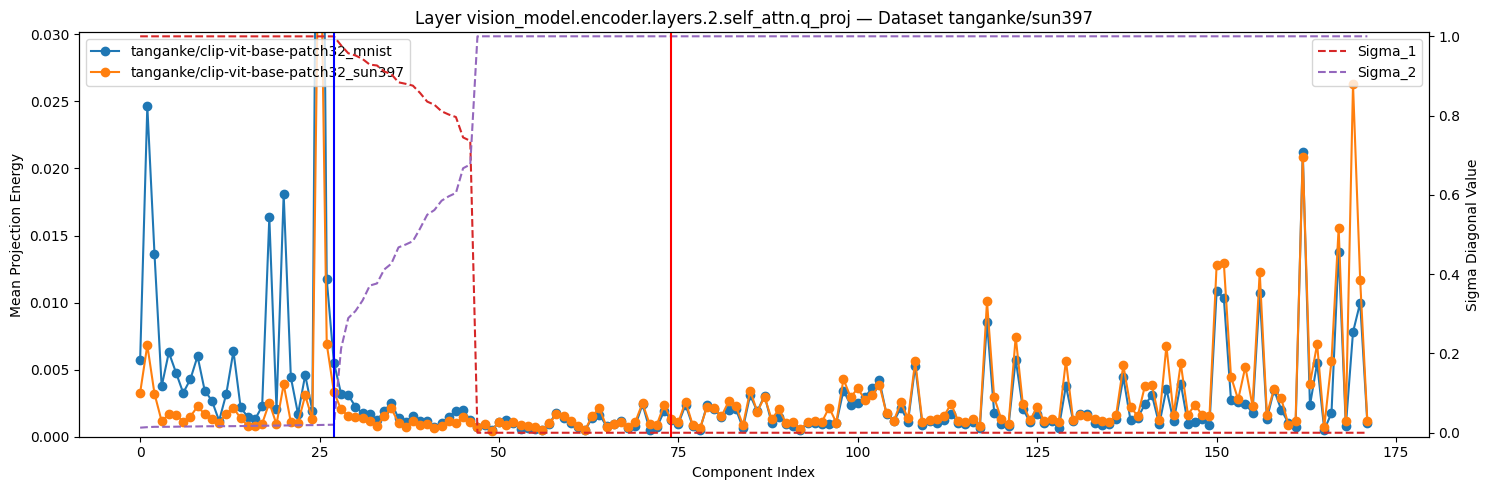

[0, 2]


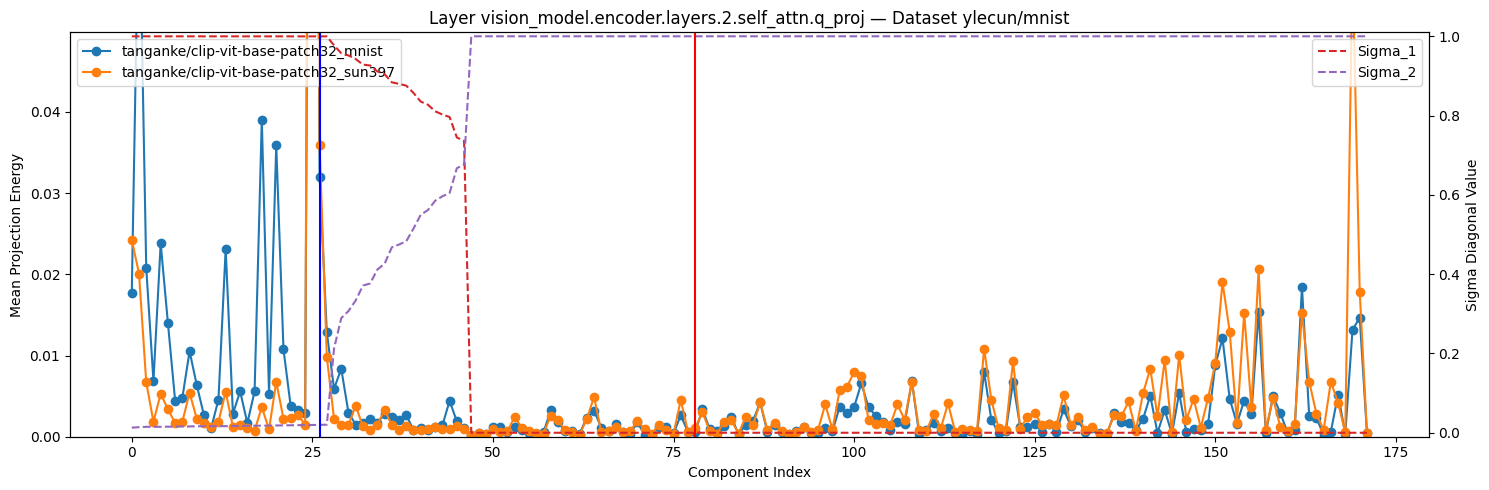

0.9999718070030212 1.0
[1, 3]


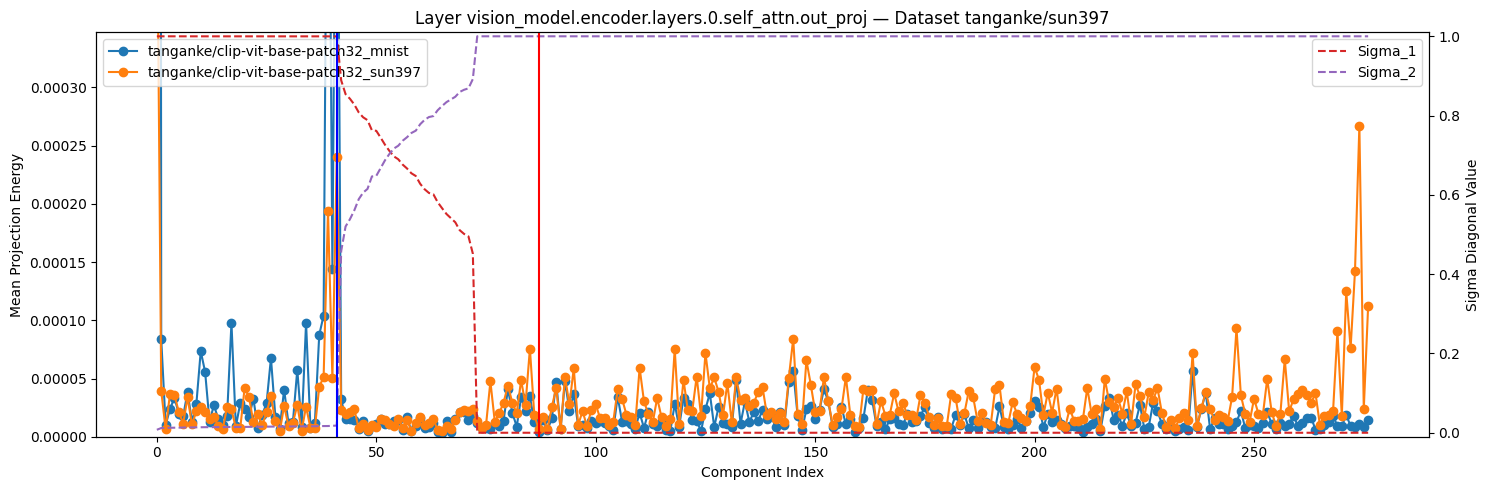

[0, 2]


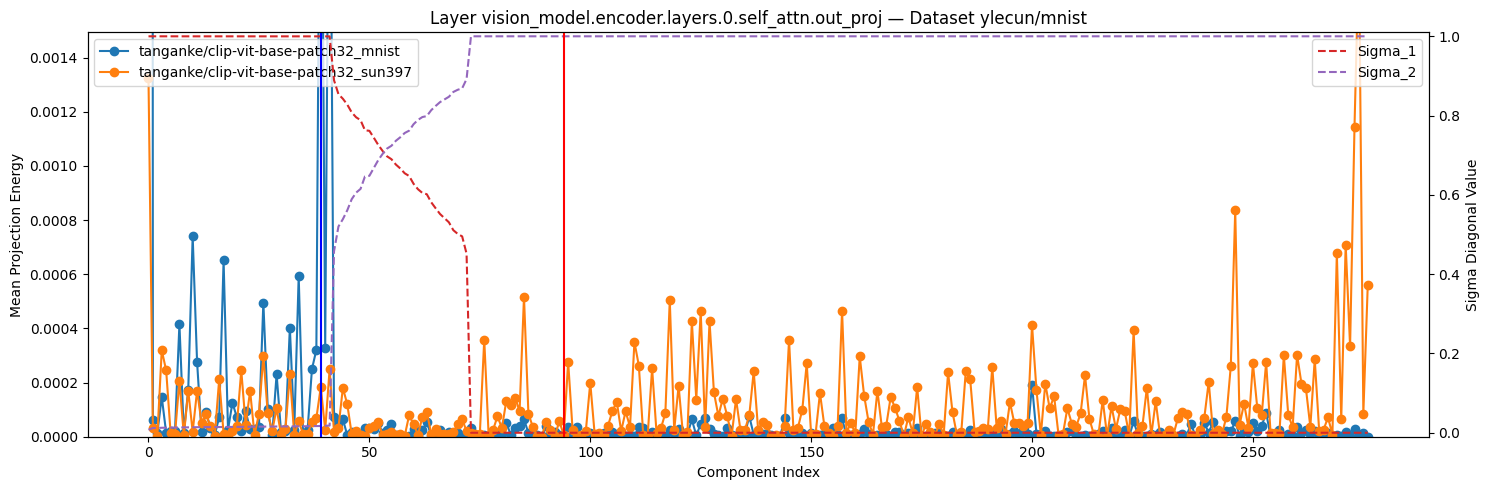

1.0002851486206055 1.0
[1, 3]


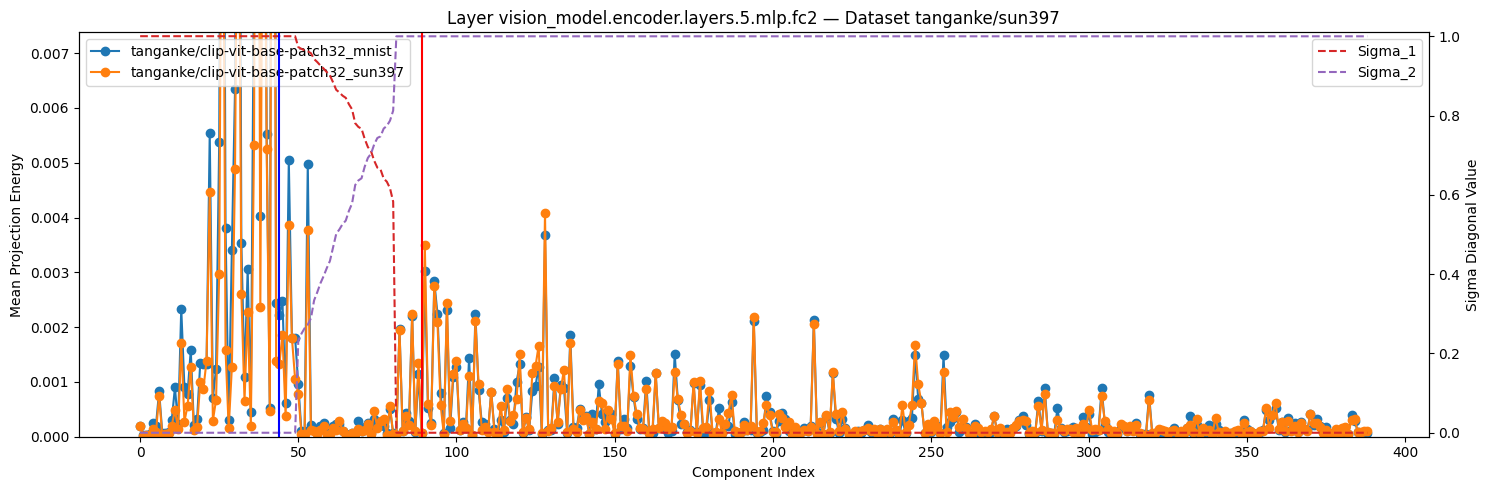

[0, 2]


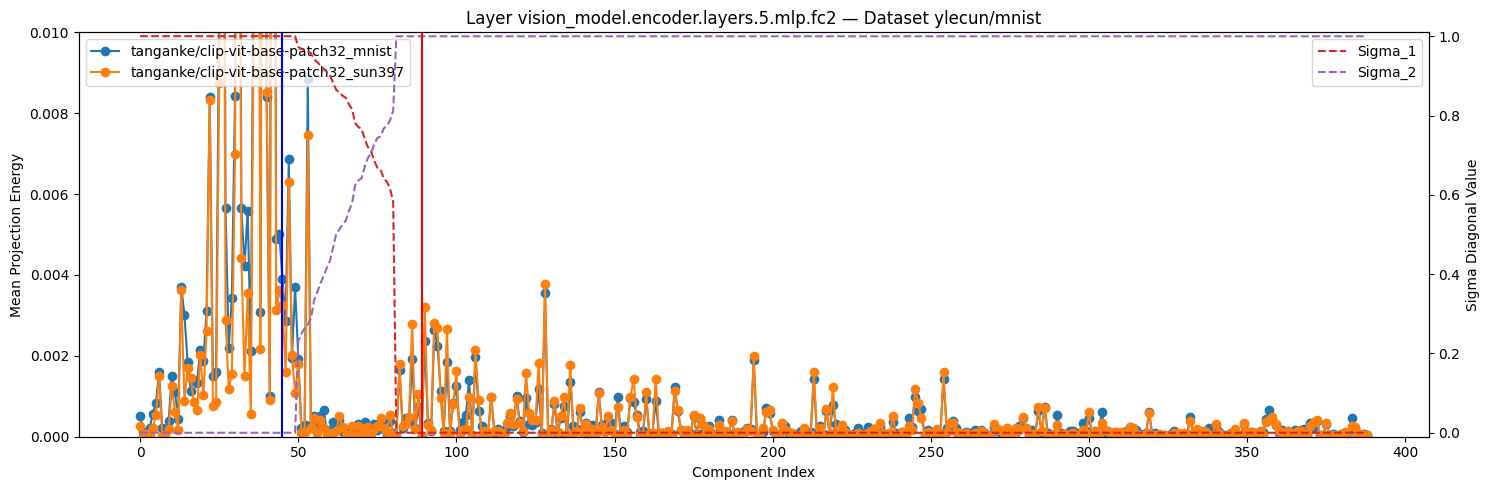

0.9999160170555115 1.0
[1, 3]


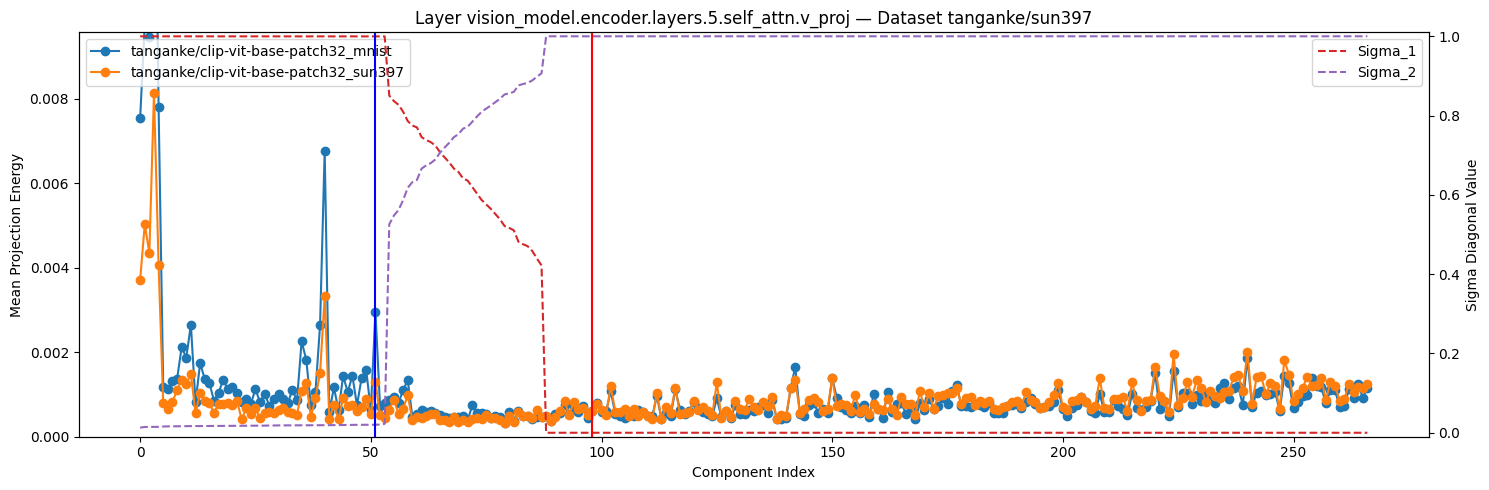

[0, 2]


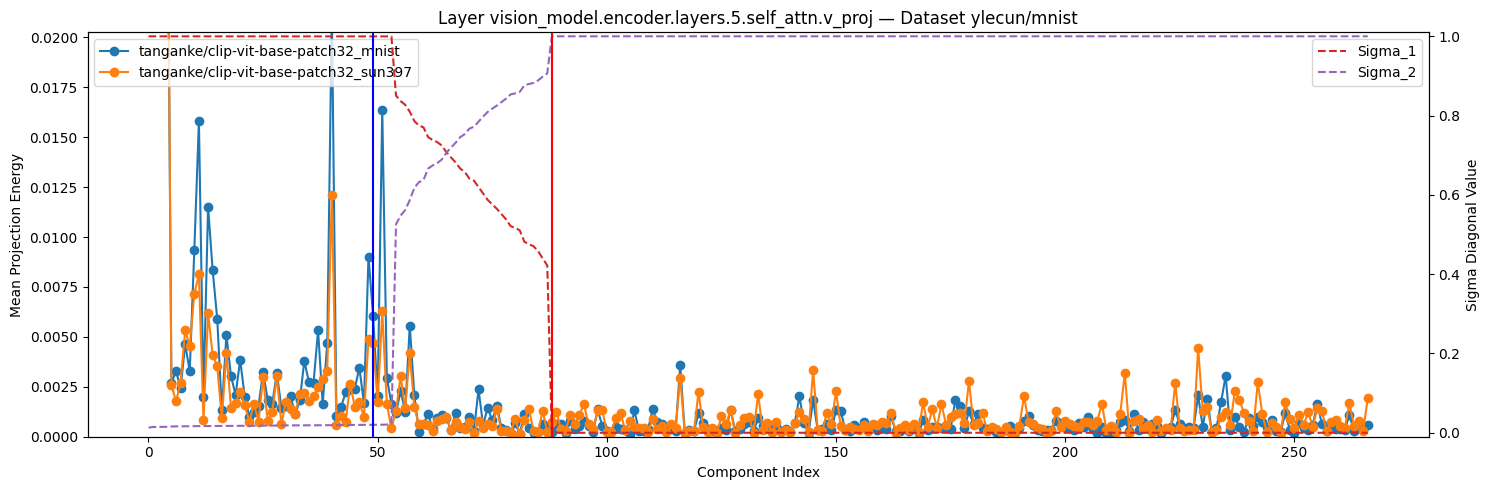

0.9999191164970398 1.0
[1, 3]


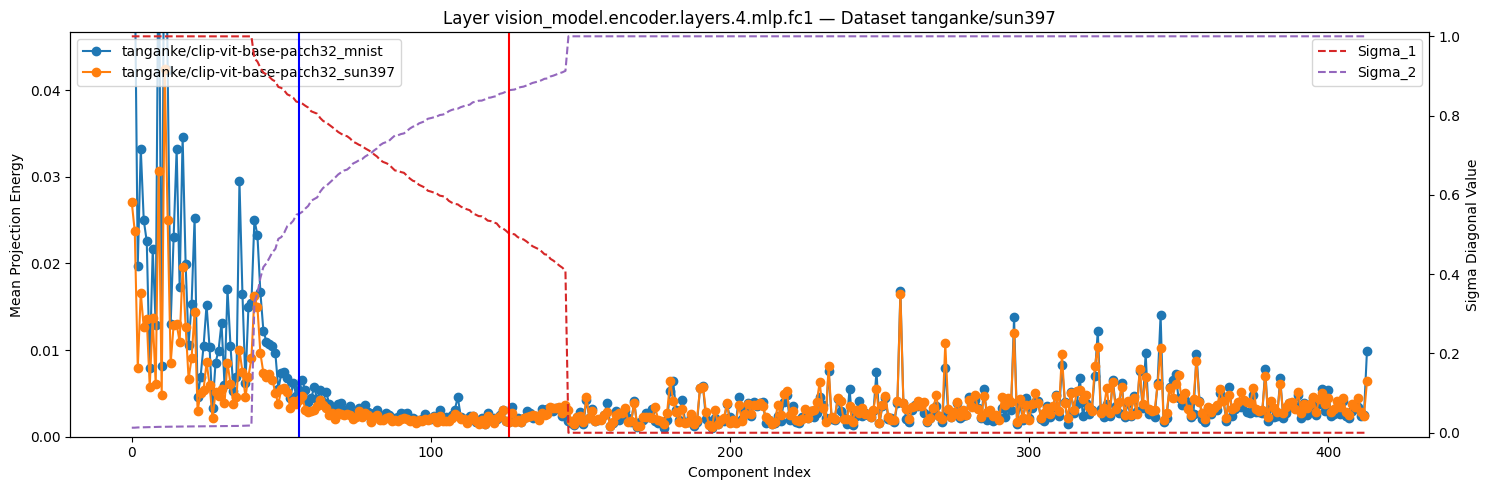

[0, 2]


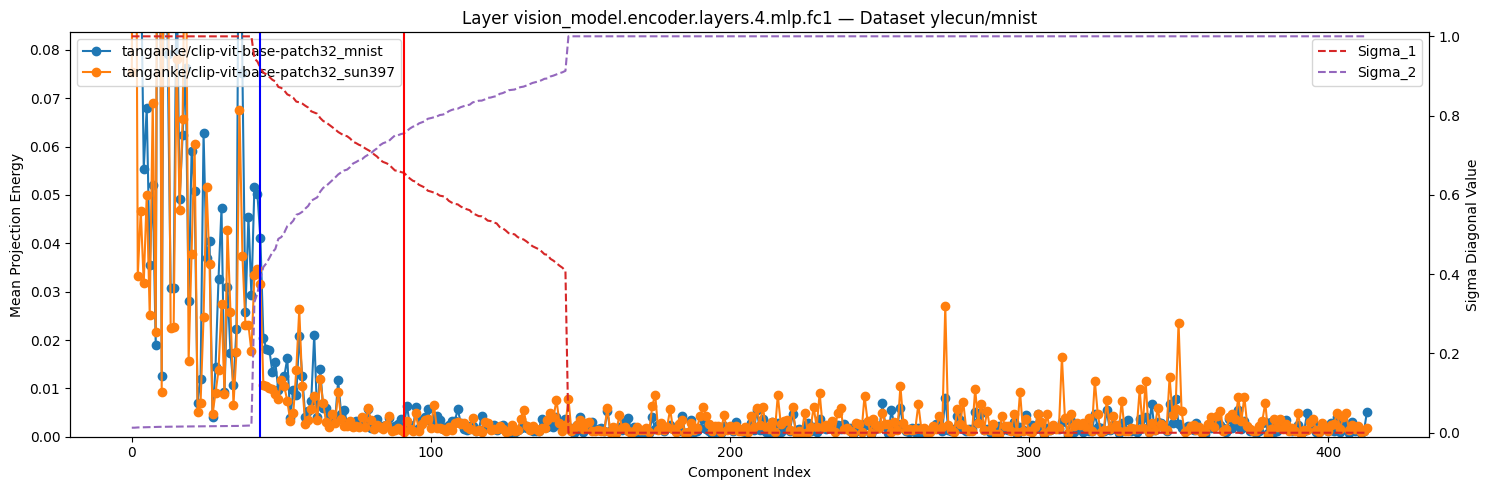

1.0003750324249268 1.0
[1, 3]


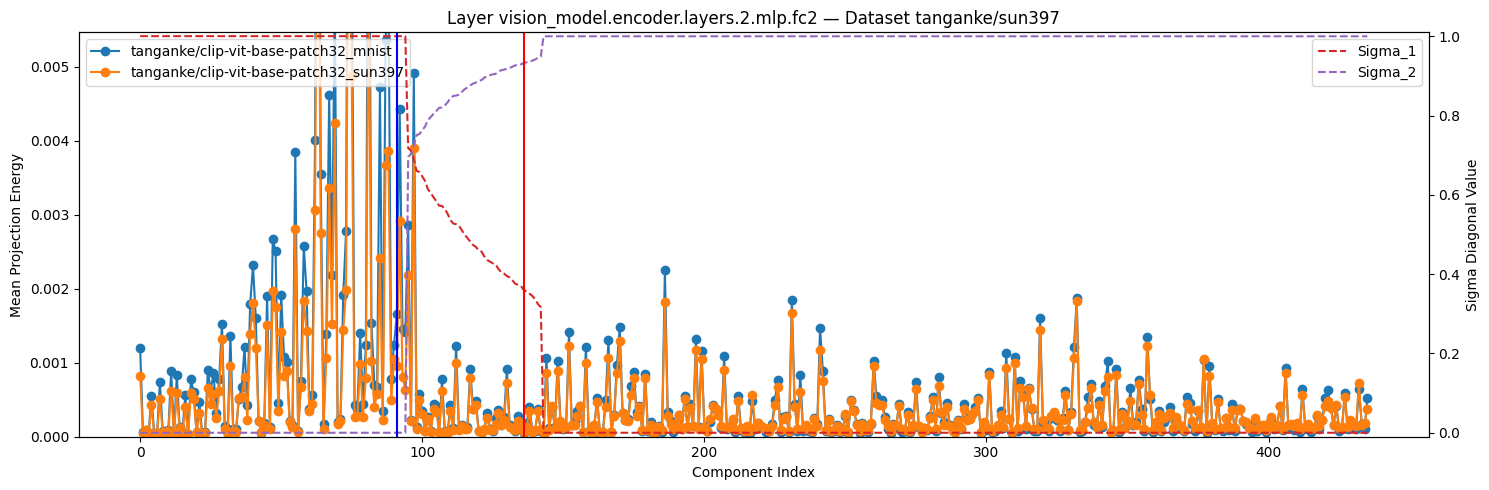

[0, 2]


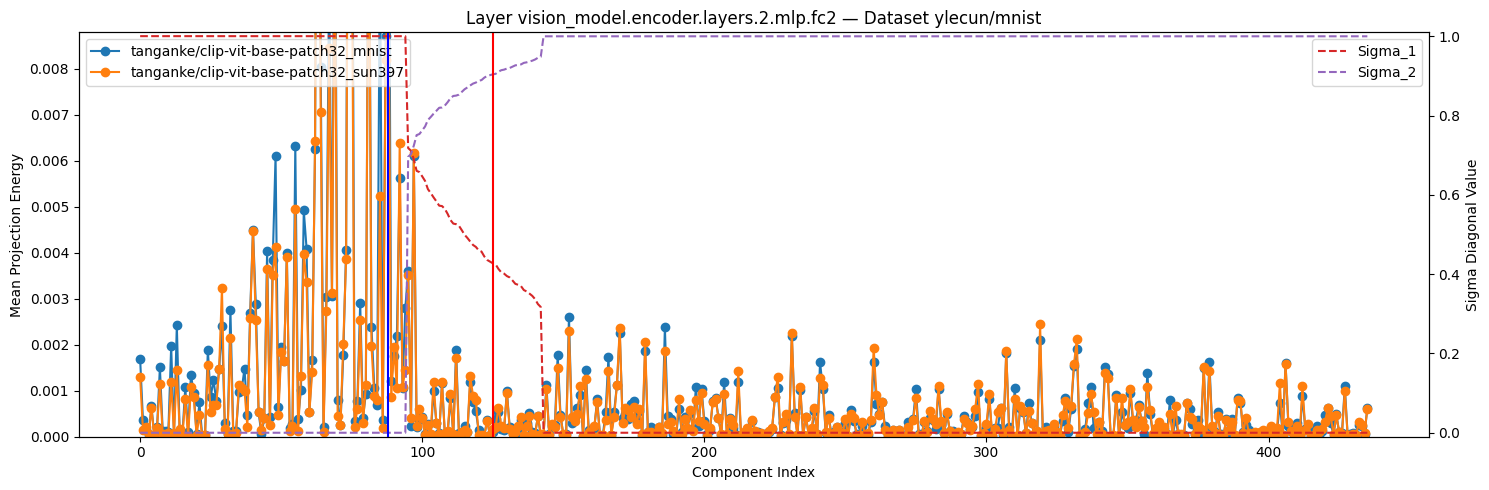

0.9999056458473206 1.0
[1, 3]


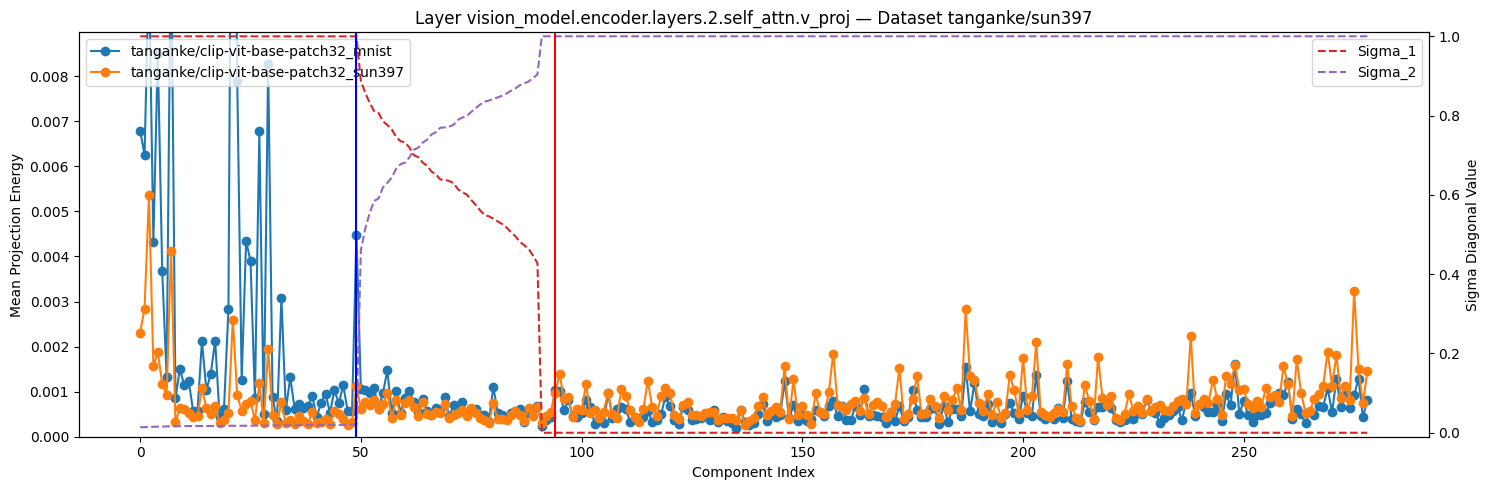

[0, 2]


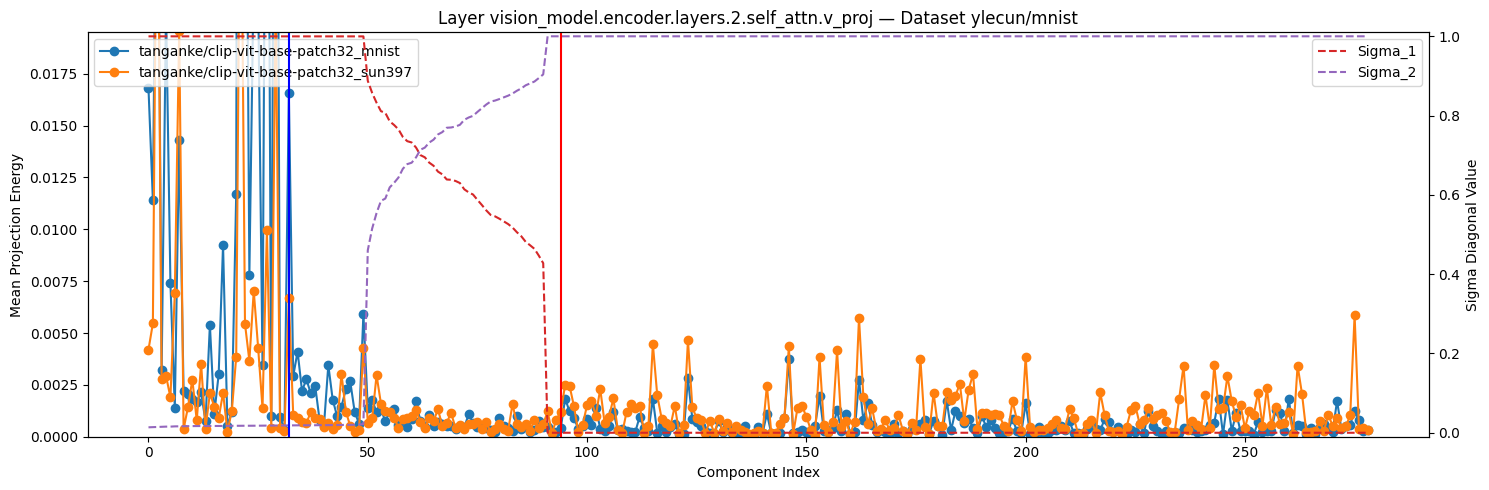

1.0003719329833984 1.0
[1, 3]


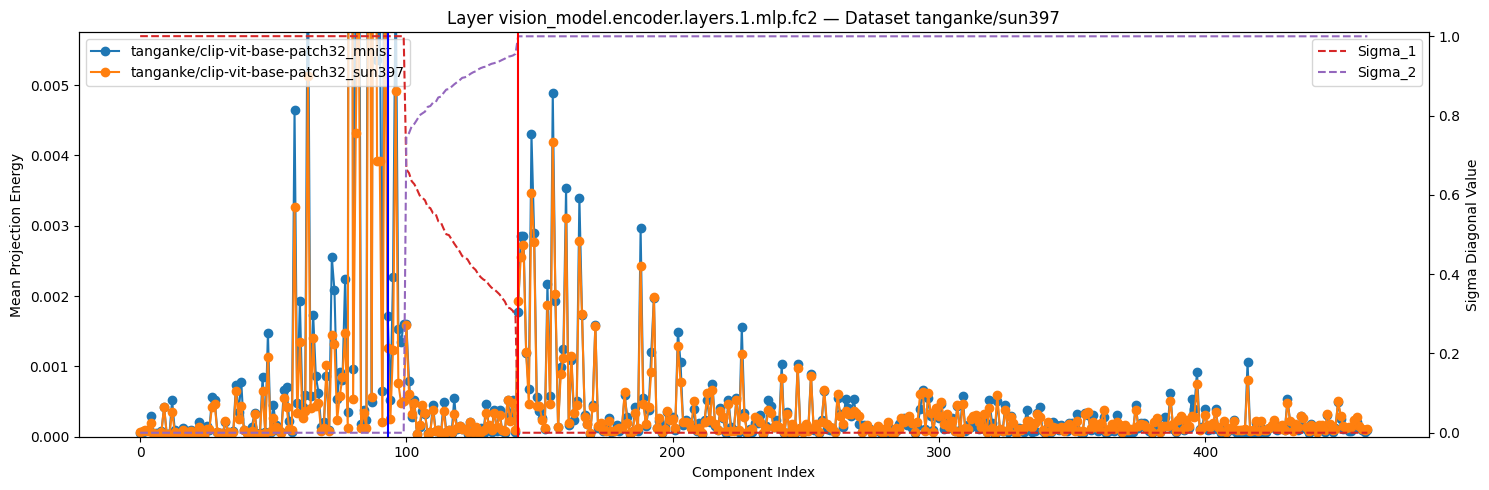

[0, 2]


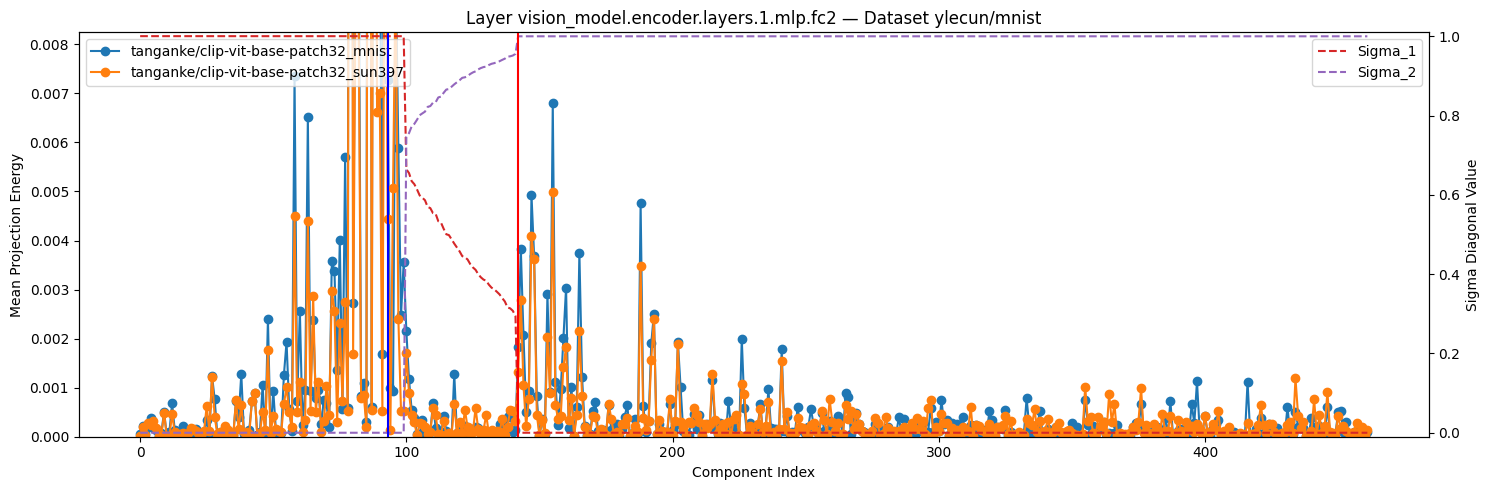

0.9999422430992126 1.0
[1, 3]


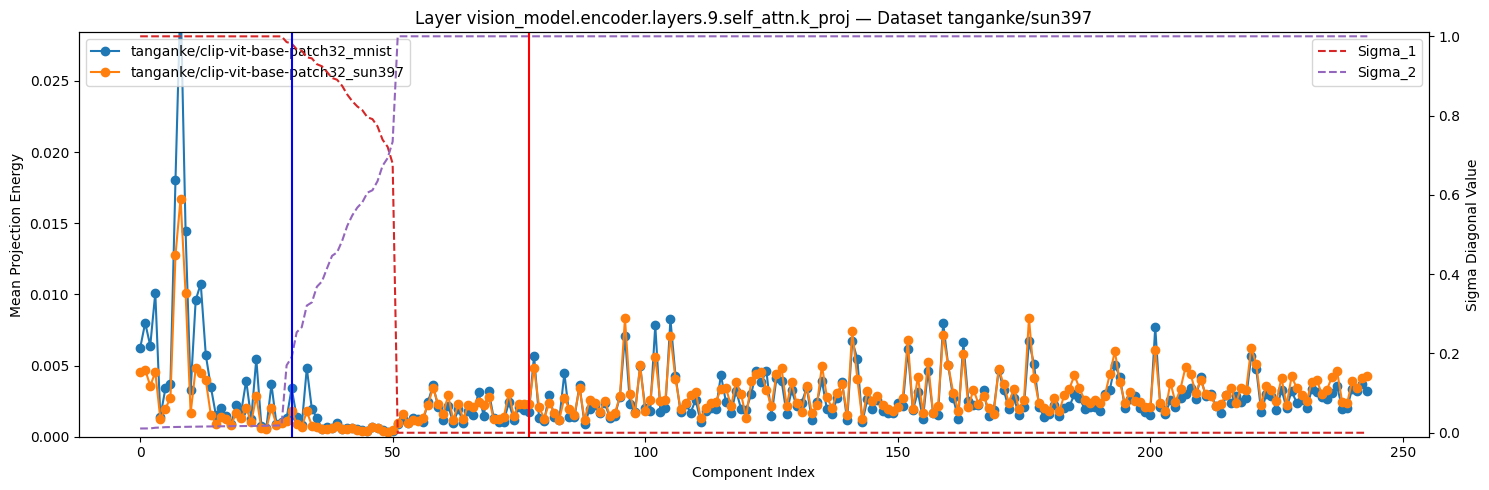

[0, 2]


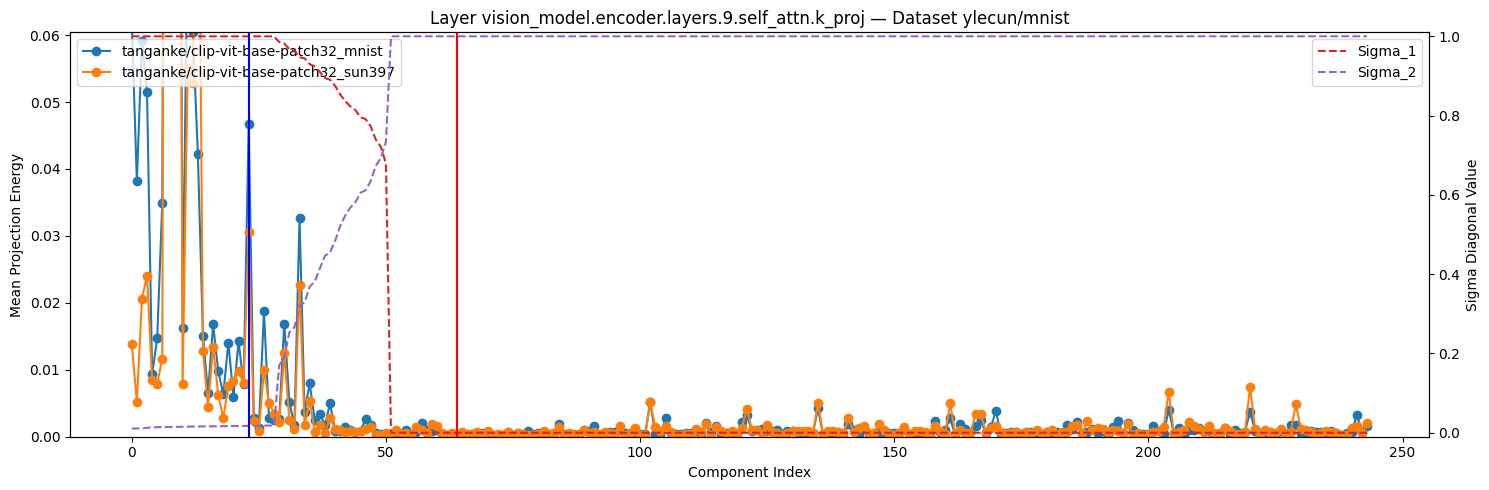

0.9998494982719421 1.0
[1, 3]


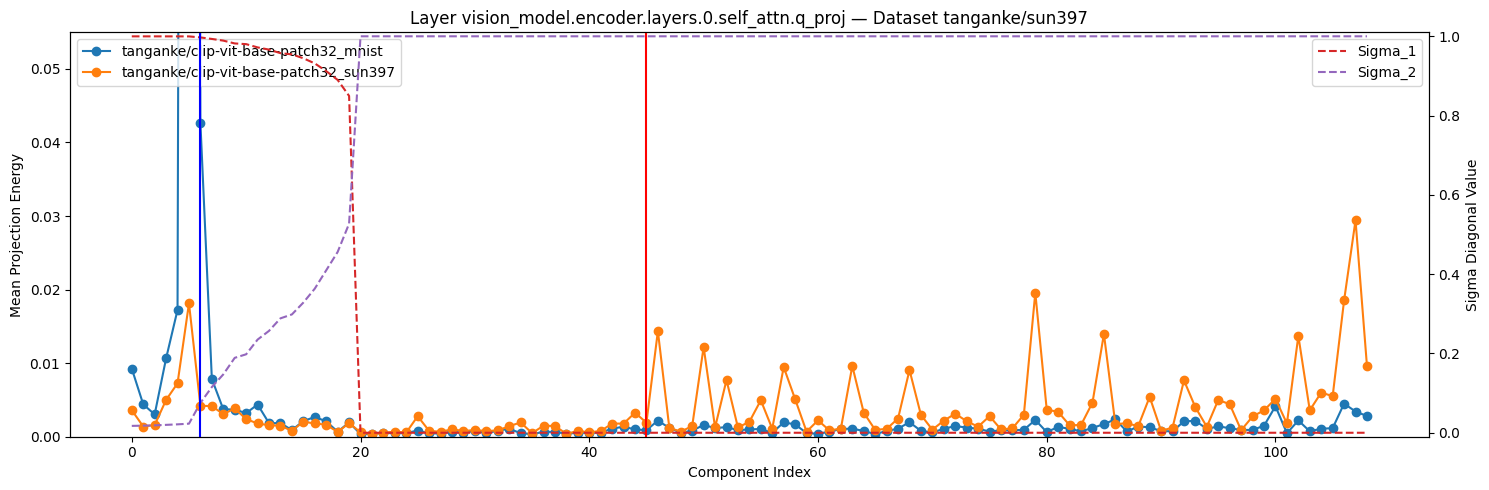

[0, 2]


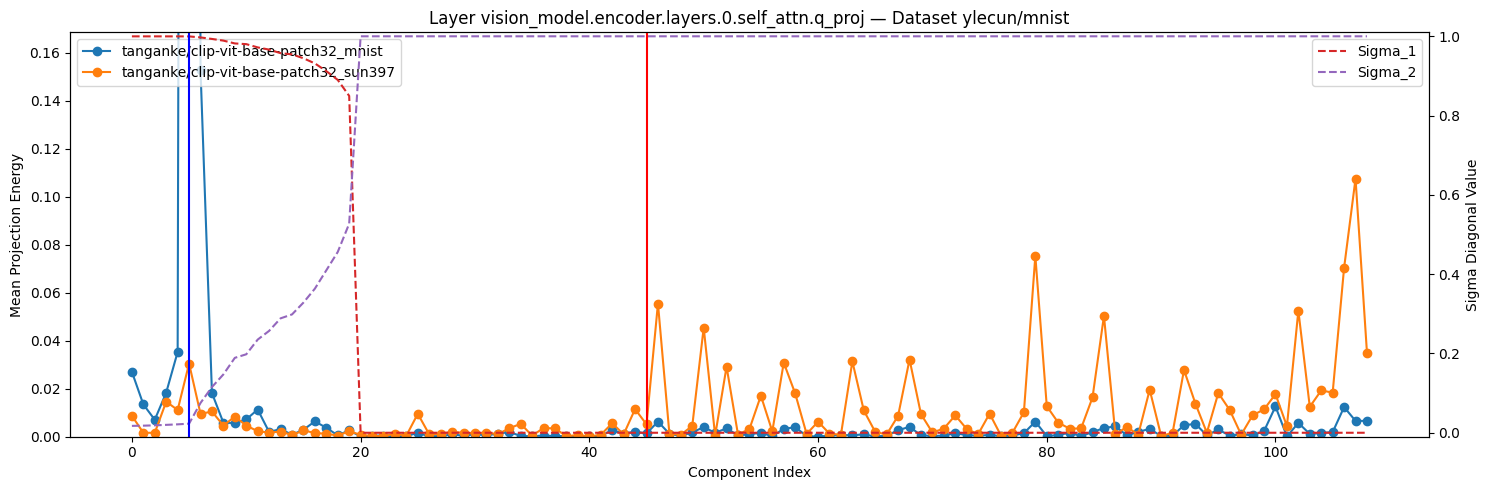

0.999893307685852 1.0
[1, 3]


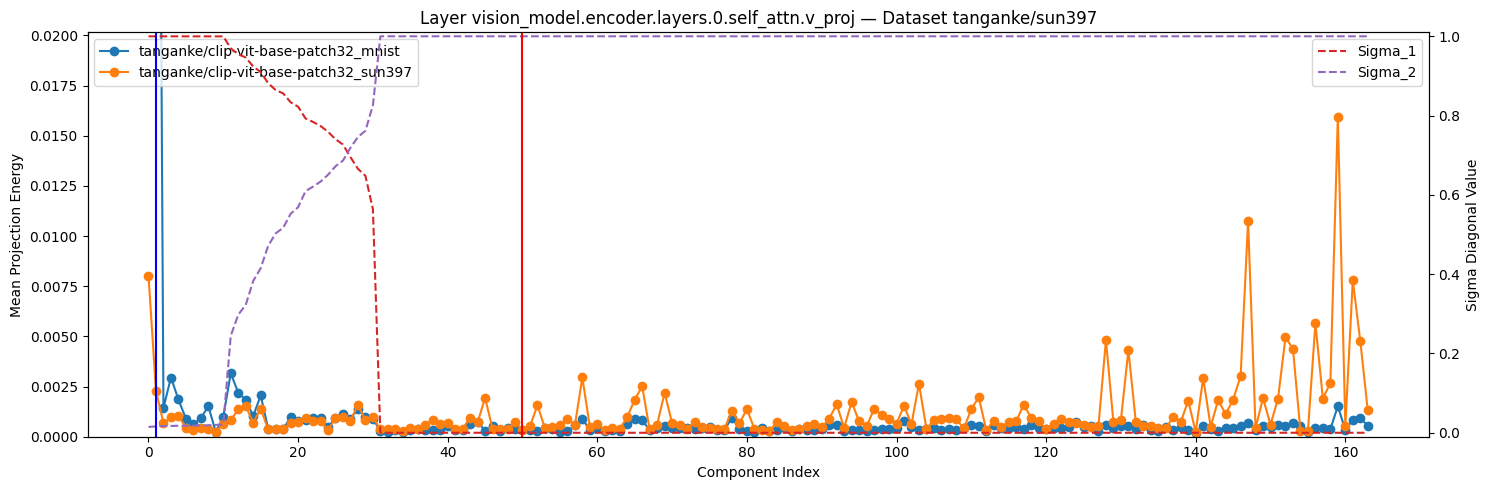

[0, 2]


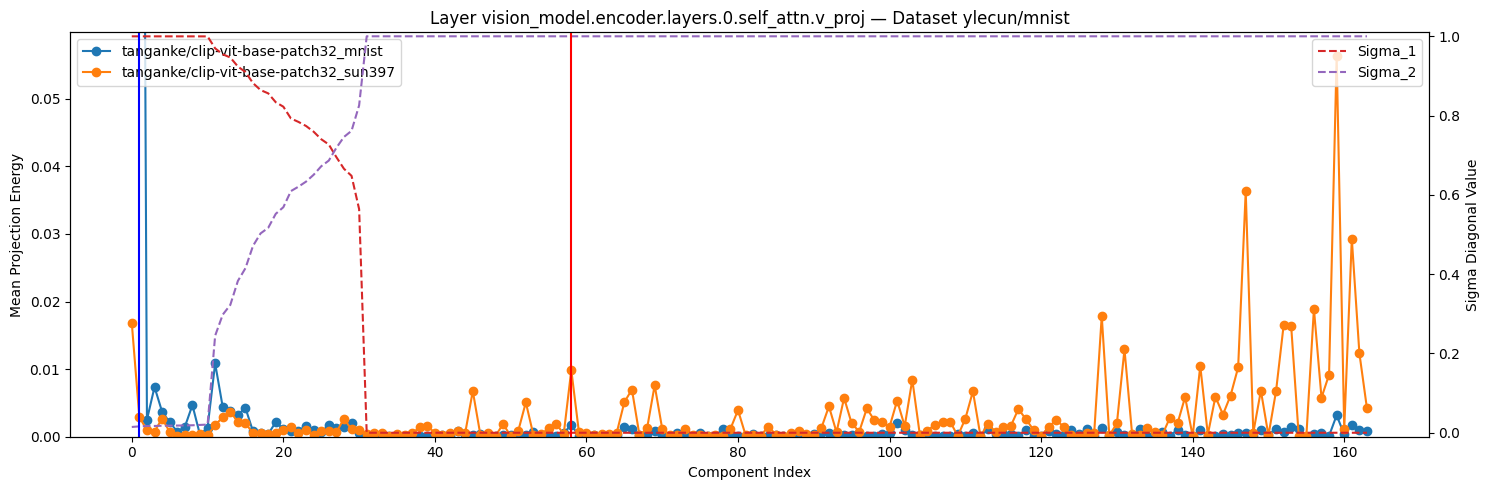

1.0003336668014526 1.0
[1, 3]


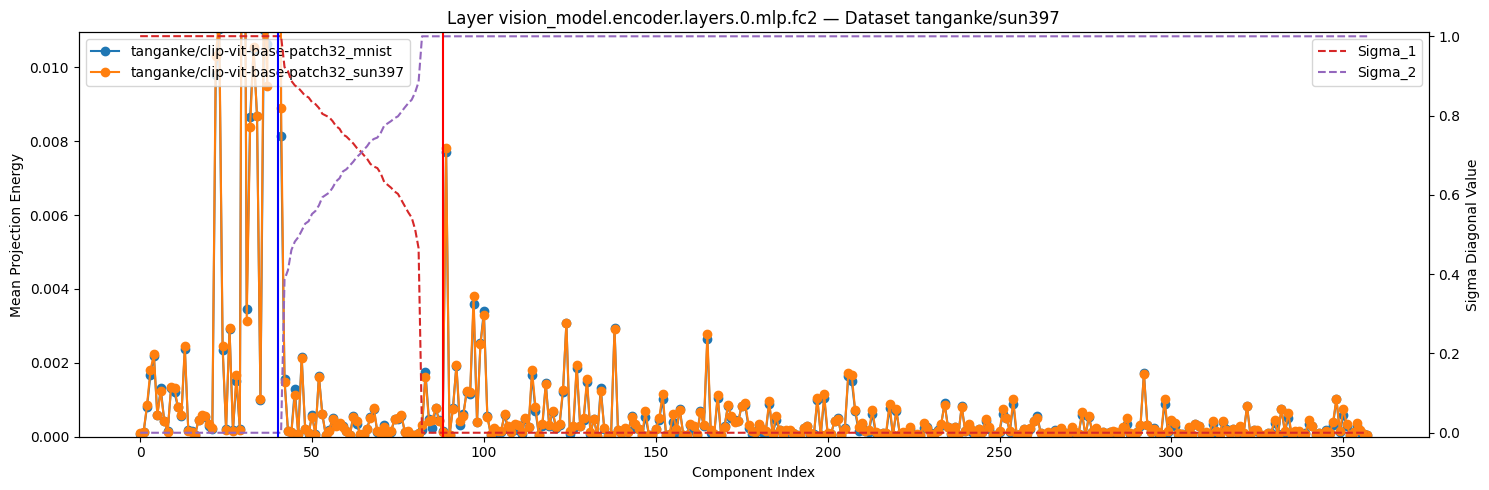

[0, 2]


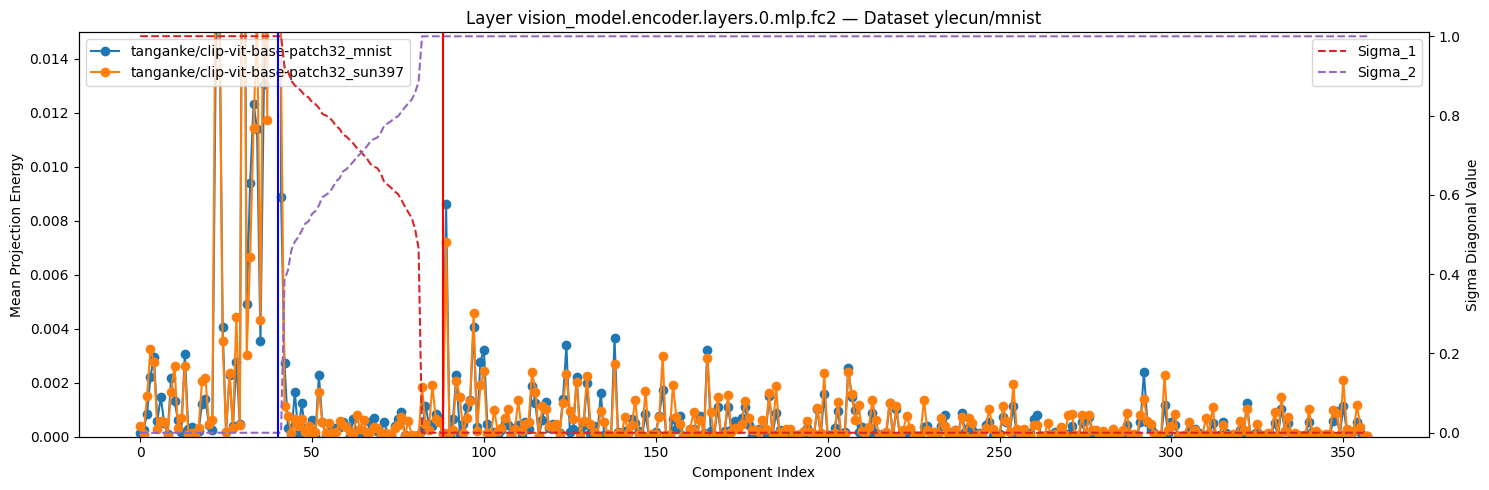

In [19]:
plot_energy_layers(energies,combos)

In [20]:
combos = list(X_dicts.keys())
print(combos)


[('tanganke/clip-vit-base-patch32_mnist', 'ylecun/mnist'), ('tanganke/clip-vit-base-patch32_mnist', 'tanganke/sun397'), ('tanganke/clip-vit-base-patch32_sun397', 'ylecun/mnist'), ('tanganke/clip-vit-base-patch32_sun397', 'tanganke/sun397')]


In [21]:
svd_dict_1 = SVD_dicts[model_names[0]]
svd_dict_2 = SVD_dicts[model_names[1]]
#ds_name = ds_info["hf_name"]


for layer_name, (U1, S1, V1) in svd_dict_1.items():
    U1 = U1.to(device)        # [d_out, r1]
    V1 = V1.to(device)        # [d_in,  r1]
    S1 = S1.to(device)
    tau1 = U1 @ torch.diag_embed(S1) @ V1.T
        
    U2, S2, V2 = svd_dict_2[layer_name]
    U2 = U2.to(device)        # [d_out, r2]
    V2 = V2.to(device)        # [d_in,  r2]
    S2 = S2.to(device)
    tau2 = U2 @ torch.diag_embed(S2) @ V2.T

    U,Sigma_1,V,Sigma_2,W,R,Q,k = gsvd(tau1,tau2)

    n=Q.shape[0]
    WtR = W.T@R
    if k < n:
        zeros_pad = torch.zeros((k, n - k), device=WtR.device, dtype=WtR.dtype)
        WtR= torch.cat([WtR, zeros_pad], dim=1)
    M = WtR@Q.T

    S_1 = Sigma_1.clone()
    S_2 = Sigma_2.clone()
    
    tau_1_f = U@Sigma_1@M
    tau_2_f = V@Sigma_2@M
    #print(torch.norm(tau1 - tau_1_p)/torch.norm(tau1),torch.norm(tau2 - tau_2_p)/torch.norm(tau2))

    shared_response = torch.diag(W.T@R@R@W)
    resp1 = torch.mul(shared_response, torch.diag(Sigma_1)**2)
    resp2 = torch.mul(shared_response, torch.diag(Sigma_2)**2)

    #tot1= resp1.sum()
    #thr1= 0.90 * tot1
    #cumsum = torch.cumsum(resp1, dim=0)
    #r1 = (cumsum >= thr1).nonzero(as_tuple=False)[0].item()
    #Sigma_1[r1:,r1:] = 0
    
    #tot2= resp2.sum()
    #thr2= 0.10 * tot2
    #cumsum = torch.cumsum(resp2, dim=0)
    #r2 = (cumsum < thr2).nonzero(as_tuple=False)[-1].item()
    #Sigma_2[:r2,:r2] = 0

    diff = torch.diag(Sigma_1) - torch.diag(Sigma_2)
    r = torch.argmin(diff.abs())
    Sigma_1[r:,r:] = 0
    Sigma_2[:r,:r] = 0
    #print(r1,r2)
    print(r)

    #print(torch.diag(Sigma_2))
  

    
    tau_1_p = U@Sigma_1@M
    tau_2_p = V@Sigma_2@M

    #print(torch.norm(tau1 - tau_1_p)/torch.norm(tau1),torch.norm(tau2 - tau_2_p)/torch.norm(tau2))

    for ds_info in dataset_infos:
        ds = ds_info["hf_name"]

        model1 = model_names[0]
        model2 = model_names[1]

        combo1 = (model1,ds)
        combo2 = (model2,ds)

        #X1 = X_dicts[combo1][layer_name]
        #H1 = H_dicts[combo1][layer_name]
        Z1 = X_dicts[combo1][layer_name].to('cuda') @ (S_1@M).T.to('cuda')
        Z2 = X_dicts[combo2][layer_name].to('cuda') @ (S_2@M).T.to('cuda')
        print(torch.norm(Z1.to('cuda')- X_dicts[combo1][layer_name].to('cuda') @ (Sigma_1@M).T.to('cuda'))
              /torch.norm(Z1),
              torch.norm(Z2.to('cuda')- X_dicts[combo2][layer_name].to('cuda') @ (Sigma_2@M).T.to('cuda'))
             /torch.norm(Z2))
       # print(torch.norm(H1.to('cuda')- X_dicts[combo1][layer_name].to('cuda') @ (Sigma_1@M).T.to('cuda'))
       #       /torch.norm(H1),
       #       torch.norm(H2.to('cuda')- X_dicts[combo2][layer_name].to('cuda') @ (Sigma_2@M).T.to('cuda'))
       #      /torch.norm(H2))
        print("======")
    
    

tensor(46, device='cuda:0')
tensor(0.0317, device='cuda:0') tensor(0.1095, device='cuda:0')
tensor(0.0507, device='cuda:0') tensor(0.1125, device='cuda:0')
tensor(53, device='cuda:0')
tensor(0.0486, device='cuda:0') tensor(0.0841, device='cuda:0')
tensor(0.1040, device='cuda:0') tensor(0.0918, device='cuda:0')
tensor(73, device='cuda:0')
tensor(0.0467, device='cuda:0') tensor(0.1285, device='cuda:0')
tensor(0.0581, device='cuda:0') tensor(0.0906, device='cuda:0')
tensor(65, device='cuda:0')
tensor(0.1125, device='cuda:0') tensor(0.1861, device='cuda:0')
tensor(0.1723, device='cuda:0') tensor(0.1235, device='cuda:0')
tensor(80, device='cuda:0')
tensor(0.1401, device='cuda:0') tensor(0.2946, device='cuda:0')
tensor(0.2178, device='cuda:0') tensor(0.2092, device='cuda:0')
tensor(96, device='cuda:0')
tensor(0.1579, device='cuda:0') tensor(0.1138, device='cuda:0')
tensor(0.1869, device='cuda:0') tensor(0.1022, device='cuda:0')
tensor(62, device='cuda:0')
tensor(0.1019, device='cuda:0') tens

In [22]:
def merge_models_gsvd(
    m1: Dict[str, torch.Tensor],
    m2: Dict[str, torch.Tensor]
)->Dict[str, torch.Tensor]:
    result_dict: Dict[str, torch.Tensor] = {}

    layers = list(m1.keys())
    for layer in layers:
        tau1 = m1[layer]
        tau2 = m2[layer]
        U,Sigma_1,V,Sigma_2,W,R,Q,k = gsvd(tau1, tau2)

        #1. clean the spectrum, making them disjoint
        E_1 = torch.mul(torch.diag(Sigma_1),torch.diag(R))**2
        E_2 = torch.mul(torch.diag(Sigma_2),torch.diag(R))**2

        
        #2. create orthonormal basis H

        #3. merge



